# Learning probability distribution

In [1]:
from ay_torch import *

In [18]:
FUNC_KIND=3
NOISE_KIND=1
def Func(x):
  global FUNC_KIND
  if FUNC_KIND==0:  return x
  if FUNC_KIND==1:  return (x[:,0]**2).reshape((-1,1))
  if FUNC_KIND==2:  return (3.0-x[:,0]).reshape((-1,1))
  if FUNC_KIND==3:  return (x[:,0]+3.0*np.sin(x[:,0])).reshape((-1,1))
  if FUNC_KIND==4:  return np.where(x[:,0]**2<1.0, 3.0, 0.0).reshape((-1,1))
  if FUNC_KIND==5:  return (3.0*(x[:,0]/2.5)+2.0*(x[:,0]/2.5)**2+1.0+3.0*np.cos(20.0*(x[:,0]/2.5))).reshape((-1,1))

def FNoiseBias(x):
  if NOISE_KIND==0:  return 1.0
  if NOISE_KIND==1:  return np.where(np.abs(x[:,0])<2.0, 4.0, 1.0).reshape((-1,1))
  if NOISE_KIND==2:  return np.where(np.abs(x[:,0])<2.0, 1.0, 4.0).reshape((-1,1))

def GenerateSample(xmin, xmax, N_sample, f, f_noise, noise=1.0e-10):
  data_x= np.random.uniform(xmin,xmax,size=(N_sample,1))
  data_y= f(data_x) + np.random.normal(scale=noise,size=(N_sample,1))*f_noise(data_x)
  return data_x,data_y

In [41]:
xmin,xmax= -5.0, 5.0
N_sample= 5000
# N_sample= 500
# N_sample= 80
#NOTE: Adjust the sample size and noise level.
data_x,data_y= GenerateSample(xmin, xmax, N_sample, Func, FNoiseBias, noise=0.2)

#Convert data to torch variables.
data_x= torch.autograd.Variable(torch.from_numpy(data_x).float())
data_y= torch.autograd.Variable(torch.from_numpy(data_y).float())

#NOTE: Adjust the batch and epoch sizes.
N_batch= 50

#Make torch dataset and loader.
test_ratio= 0.2
idxes= np.random.RandomState(seed=42).permutation(data_x.shape[0])
N_train= round(data_x.shape[0]*(1.-test_ratio))
dset_train= torch.utils.data.TensorDataset(data_x[idxes[:N_train]], data_y[idxes[:N_train]])
dset_test= torch.utils.data.TensorDataset(data_x[idxes[N_train:]], data_y[idxes[N_train:]])
dl_train= torch.utils.data.DataLoader(
      dataset=dset_train,
      batch_size=N_batch,
      shuffle=True,
      drop_last=True,
      num_workers=2)
dl_test= torch.utils.data.DataLoader(
      dataset=dset_train,
      batch_size=N_batch,
      shuffle=True,
      num_workers=2)

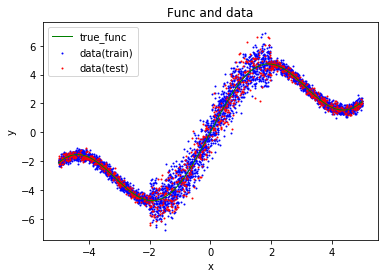

In [42]:
# %matplotlib widget
fig= plt.figure()
ax_pred= fig.add_subplot(1,1,1,title='Func and data',xlabel='x',ylabel='y')
true_x= np.linspace(xmin,xmax,1000).reshape((-1,1))
ax_pred.plot(true_x, Func(true_x), color='green', linewidth=1, label='true_func')
ax_pred.scatter(data_x[idxes[:N_train]], data_y[idxes[:N_train]], s=1, color='blue', label='data(train)')
ax_pred.scatter(data_x[idxes[N_train:]], data_y[idxes[N_train:]], s=1, color='red', label='data(test)')
ax_pred.legend()
plt.show()

## Network definition

In [23]:
class TELUPlusOne(torch.nn.Module):
  def __init__(self, *args, **kwargs):
    super(TELUPlusOne,self).__init__()
  def forward(self, x):
    return torch.nn.functional.elu(x)+1.0#+1e-8

class TLeakyReLUWithOffset(torch.nn.Module):
  def __init__(self, *args, **kwargs):
    super(TLeakyReLUWithOffset,self).__init__()
  def forward(self, x):
    return torch.nn.functional.leaky_relu(x,negative_slope=-0.0)+1e-8

class TResDenseNetProb(torch.nn.Module):
  def __init__(self, in_channels, out_channels, hidden_channels=256, net_args=None, mu_args=None, sigma_args=None, p_dropout=0.0):
    super(TResDenseNetProb,self).__init__()
    default_net_args= dict(
      layers=[
        ('Dense',dict(out_channels=hidden_channels)),
        torch.nn.Dropout(p_dropout),
        ('ResDense',dict(out_channels=hidden_channels)),
        torch.nn.Dropout(p_dropout),
        ('ResDense',dict(out_channels=hidden_channels)),
        torch.nn.Dropout(p_dropout),
        ('ResDense',dict(out_channels=hidden_channels)),
      ])
    net_args= MergeDict(default_net_args,net_args) if net_args else default_net_args
    default_mu_args= dict(
      layers=[
        ('Linear',dict(out_features=out_channels)),
      ])
    mu_args= MergeDict(default_mu_args,mu_args) if mu_args else default_mu_args
    default_sigma_args= dict(
      layers=[
        ('Linear',dict(out_features=out_channels)),
        TELUPlusOne(),
        # TLeakyReLUWithOffset(),
      ])
    sigma_args= MergeDict(default_sigma_args,sigma_args) if sigma_args else default_sigma_args
    self.net= TNetGenerator((in_channels,), **net_args)
    self.mu= TNetGenerator((hidden_channels,), **mu_args)
    self.sigma= TNetGenerator((hidden_channels,), **sigma_args)
    InitCNN(self)
  def forward(self, x):
    h= self.net(x)
    mu= self.mu(h)
    sigma= self.sigma(h)
    return mu,sigma

class TNormalParamLoss1(torch.nn.Module):
  def __init__(self):
    super(TNormalParamLoss1,self).__init__()
  def state_dict(self):
    return {}
  def load_state_dict(self, d):
    pass
  def __call__(self, y_pred, y_trg):
    mu,sigma= y_pred
    q= torch.distributions.Normal(mu, sigma)
    return torch.mean(-q.log_prob(y_trg))

class TNormalParamLoss2(torch.nn.Module):
  def __init__(self, w_mse=1e+2):
    super(TNormalParamLoss2,self).__init__()
    self.w_mse= w_mse
  def state_dict(self):
    return dict(w_mse=self.w_mse)
  def load_state_dict(self, d):
    self.w_mse= d['w_mse']
  def __call__(self, y_pred, y_trg):
    mu,sigma= y_pred
    q= torch.distributions.Normal(mu, sigma)
    mse= torch.nn.functional.mse_loss(mu,y_trg)
    return torch.mean(-q.log_prob(y_trg)) + self.w_mse*mse

In [327]:
net= TResDenseNetProb(1,1)

In [332]:
mu,sigma= net(torch.randn(3,1))
# ??torch.randn
# torch.randn(3,1)
q= torch.distributions.Normal(mu, sigma)
-q.log_prob(torch.randn(3,1))

tensor([[1.8309],
        [2.0630],
        [1.8818]], grad_fn=<NegBackward>)

## Train and test

In [43]:
#Setup a neural network.
net= TResDenseNetProb(in_channels=1, out_channels=1)

device= torch.device('cpu')
# device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
# f_loss= TNormalParamLoss1()
f_loss= TNormalParamLoss2()

def rmse(y,y_trg):
  mu,sigma= y
  return torch.sqrt(torch.nn.functional.mse_loss(mu,y_trg))
f_metric= rmse

def decode(pred):
  return pred

def tfm_batch(batch):
  x,y= batch
  return torch.autograd.Variable(x), torch.autograd.Variable(y)
logger= TLogger()
disp= TDisp()

In [44]:
def f_viz():
  logger.Show()
  # %matplotlib widget
  fig= plt.figure()
  ax_pred= fig.add_subplot(1,1,1,title='Func and data',xlabel='x',ylabel='y')
  true_x= np.linspace(xmin,xmax,1000).reshape((-1,1))
  pred_mu,pred_sigma= Eval(net, torch.from_numpy(true_x).float(), device=device)
  pred_mu,pred_sigma= pred_mu.cpu(),pred_sigma.cpu()
  ax_pred.plot(true_x, Func(true_x), color='green', linewidth=1, label='true_func')
  ax_pred.scatter(data_x[idxes[:N_train]], data_y[idxes[:N_train]], s=1, color='blue', label='data(train)')
  ax_pred.scatter(data_x[idxes[N_train:]], data_y[idxes[N_train:]], s=1, color='red', label='data(test)')
  ax_pred.plot(true_x, pred_mu, color='magenta', linewidth=2, label='prediction')
  ax_pred.plot(true_x, pred_mu+pred_sigma, color='magenta', linewidth=1)
  ax_pred.plot(true_x, pred_mu-pred_sigma, color='magenta', linewidth=1)
  ax_pred.legend()

In [96]:
Summary(net, input_size=(3,1))

input_size=(3, 1)
Layer (type (var_name))                       Input Shape               Output Shape              Param #
TResDenseNetProb                              --                        --                        --
├─TNetGenerator (net)                         [3, 1]                    [3, 256]                  --
│    └─Sequential (0)                         [3, 1]                    [3, 256]                  --
│    │    └─Linear (0)                        [3, 1]                    [3, 256]                  512
│    │    └─BatchNorm1d (1)                   [3, 256]                  [3, 256]                  512
│    │    └─LeakyReLU (2)                     [3, 256]                  [3, 256]                  --
│    └─Dropout (1)                            [3, 256]                  [3, 256]                  --
│    └─TResDenseBlock (2)                     [3, 256]                  [3, 256]                  --
│    │    └─Sequential (densepath)            [3, 256]            

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


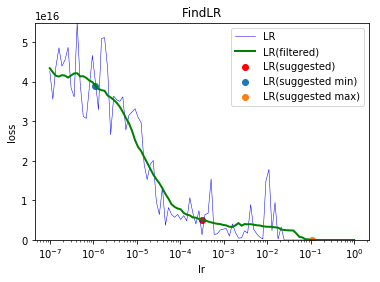

lr= 0.00031622776601683794, lr_min=1.1220184543019633e-06, lr_max=0.10471285480508992


In [14]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(train)	metric(test)	 time
0	548.63899240	42.72663279	1.95749904	0.63583486	 0.843712
1	113.83481851	72.31262221	1.00641499	0.83535067	 0.792855
2	132.36174498	43.36021781	1.09968992	0.64209524	 0.817463
3	106.81874027	66.00276442	0.98873532	0.79922018	 0.804029
4	115.32412610	76.30918036	1.00736374	0.86135718	 0.814138
5	111.96804419	39.87265179	0.99801256	0.61859269	 0.767321
6	124.46939321	47.86022637	1.05594228	0.67841704	 0.831381
7	86.17994294	45.35626090	0.87816449	0.65610743	 0.774759
8	109.49426796	63.24782972	0.99729776	0.78136679	 0.782509
9	94.08431649	50.08057468	0.92544084	0.69528209	 0.778591
10	97.47378342	35.60149894	0.93127983	0.58216864	 0.807692
11	92.19322424	45.27730231	0.90462039	0.65632328	 0.793431
12	82.30533836	31.24180110	0.86706635	0.54610004	 0.787127
13	81.36903467	37.01338596	0.85794002	0.59383734	 0.811243
14	74.02182386	48.00238080	0.82040243	0.68192083	 0.793666
15	80.92276151	53.84719284	0.85382993	0.71977088	 0.7

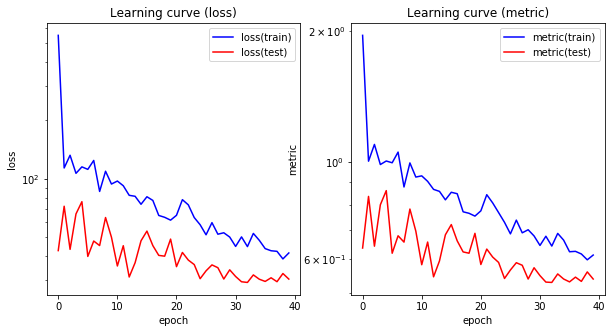

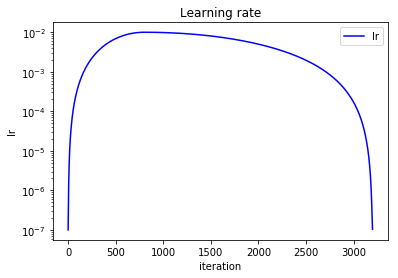

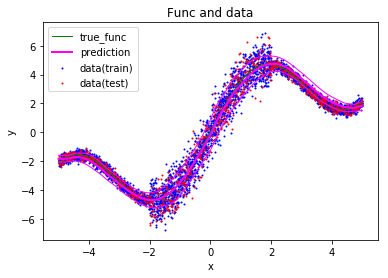

In [45]:
lr_min,lr_max= 1e-7,1e-2
# lr_min,lr_max= 1e-7,1e-4
for i in range(1):
  FitOneCycle(net, n_epoch=40*5000//N_sample, lr_max=lr_max, div_init=lr_max/lr_min, 
      opt=opt, f_loss=f_loss, f_metric=f_metric,
      dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
      callbacks=(logger.Callbacks(),disp.Callbacks()),
      device=device)
# logger.Show()
f_viz()

total epochs: 20
total time: 0.06min
best loss(train): 2.7292982637882233@15
best loss(test): 2.3307171761989594@15
best metric(train): 0.7526471950113773@15
best metric(test): 0.5768484212458134@13
last loss(train): 2.9448860585689545@20
last loss(test): 2.524034321308136@20
last metric(train): 0.8013006523251534@20
last metric(test): 0.6144555807113647@20


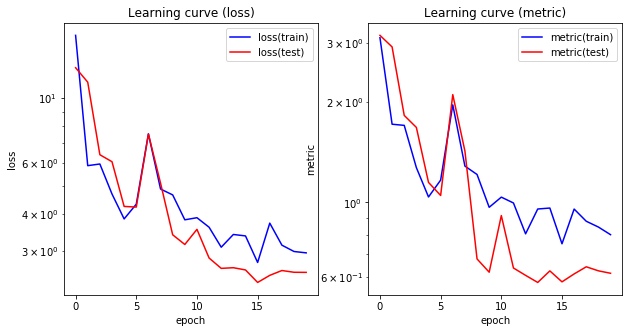

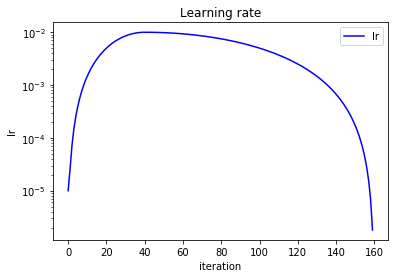

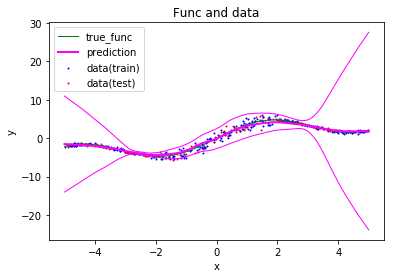

In [207]:
f_viz()

## N_sample=80

total epochs: 2500
total time: 2.62min
best loss(train): 12.897187232971191@2186
best loss(test): 22.58332633972168@2468
best metric(train): 0.3577360510826111@2186
best metric(test): 0.4522234024479985@2123
last loss(train): 26.320331573486328@2500
last loss(test): 23.568064033985138@2500
last metric(train): 0.5108180046081543@2500
last metric(test): 0.4824212519451976@2500


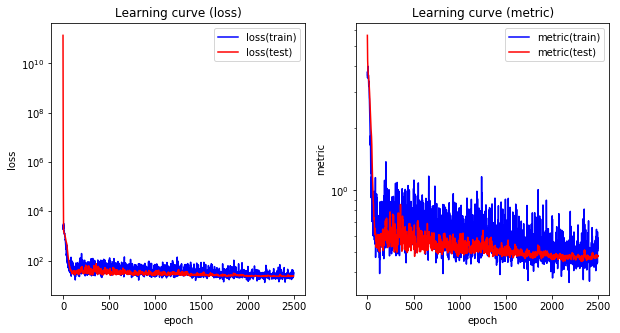

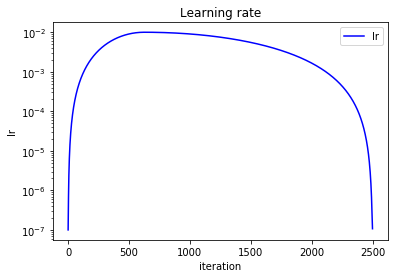

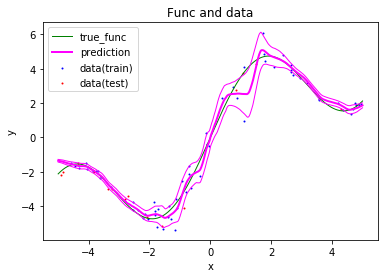

In [28]:
f_viz()

## N_sample=200

total epochs: 1000
total time: 1.35min
best loss(train): 21.993525822957356@949
best loss(test): 23.500184416770935@749
best metric(train): 0.46049561103185016@949
best metric(test): 0.47615811601281166@681
last loss(train): 26.09007199605306@1000
last loss(test): 25.86055076122284@1000
last metric(train): 0.5041922926902771@1000
last metric(test): 0.5024800878018141@1000


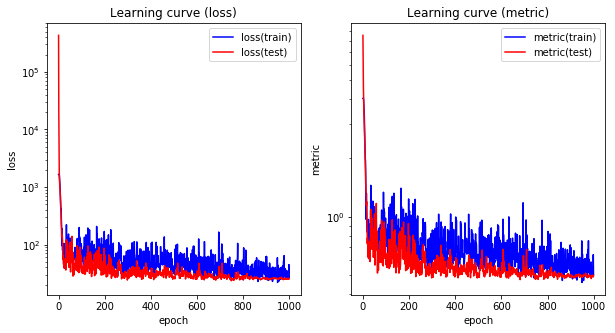

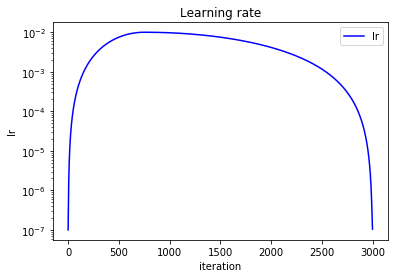

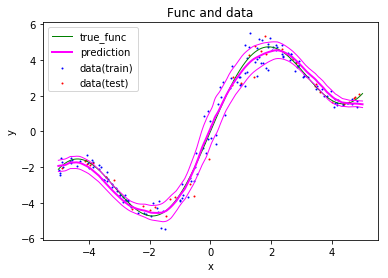

In [34]:
f_viz()

## N_sample=500

total epochs: 400
total time: 0.81min
best loss(train): 27.634868621826172@387
best loss(test): 27.234205722808838@247
best metric(train): 0.515059407800436@387
best metric(test): 0.5105839557945728@247
last loss(train): 40.92280387878418@400
last loss(test): 30.655914545059204@400
last metric(train): 0.5988431125879288@400
last metric(test): 0.5435076579451561@400


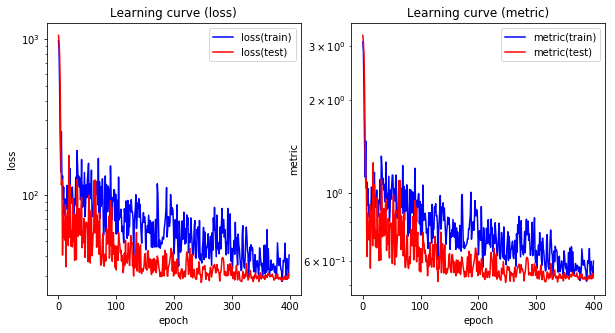

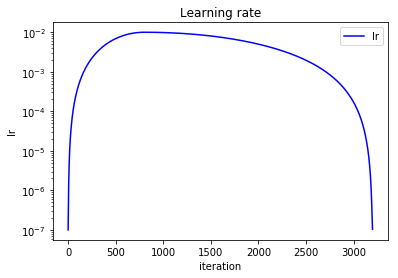

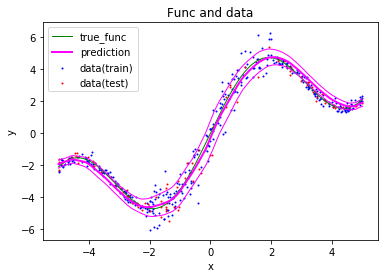

In [40]:
f_viz()

## N_sample=5000

total epochs: 40
total time: 0.42min
best loss(train): 38.71181514263153@38
best loss(test): 29.288646924495698@32
best metric(train): 0.5974301777780056@38
best metric(test): 0.5300798073410988@32
last loss(train): 41.54443533420563@40
last loss(test): 30.480896770954132@40
last metric(train): 0.6127037886530161@40
last metric(test): 0.5397428147494793@40


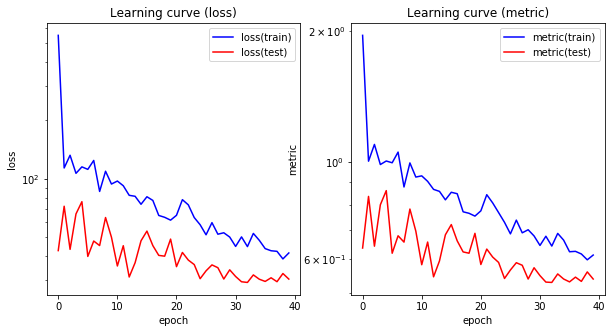

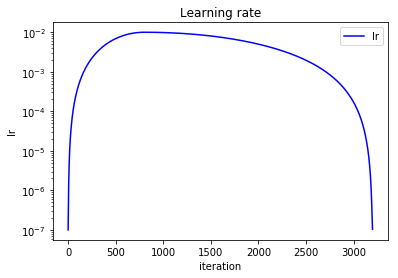

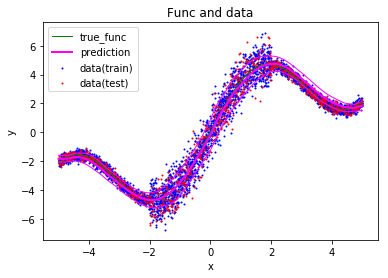

In [46]:
f_viz()